# Self-Similarity with Ternary and Multiple Pitch Differentials

In this notebook we use relations between vertical consonances of pitches to produce Transition Matrices. For example,
For the chord $[60, 64, 67]$ (C, E, G) and $[60, 65, 69]$ (C, F, A) in Midi pitches. We compare the pitch relation of every note of the first chord to the second thus the transition matrix of the actual pitch chances is :
$$  \begin{bmatrix}
    -7 & -2 & 2\\
    -4 & 1 & 5\\
    0 & 5 & 9
    \end{bmatrix}
$$

and in ternary : 
$$  \begin{bmatrix}
    -1 & -1 & 1\\
    -1 & 1 & 1\\
    0 & 1 & 1
    \end{bmatrix}
$$

Let $a \in\mathbb{Z}^n$, $b \in\mathbb{Z}^m$ be two vectors, i.e. chords in MIDI notes (Can also be reals with midi cents). 
Then the transition matrix is : 
    $$T(a, b) = \sum_{i=1}^n \sum_{j=1}^m b_j - a_i \text{ or in ternary } T(a, b) = \sum_{i=1}^n \sum_{j=1}^m sign(b_j - a_i)$$

In [1]:
import partitura
import numpy as np
import itertools

from showScore import showScore

In [2]:
part = partitura.load_musicxml("tests/data/xml/score_test.musicxml")
# print(part.pretty())
pianoroll = [(n.start.t, n.end.t, n.midi_pitch) for n in part.notes]
# print(pianoroll)
chords = [list(item[1]) for item in itertools.groupby(sorted(pianoroll), key=lambda x: x[0])]
# print(chords)

showScore("score_test.musicxml")

OSError: Error reading file 'tests/data/xml/score_test.musicxml': failed to load external entity "tests/data/xml/score_test.musicxml"

In [2]:
def pianoroll2chords(pianoroll):
    '''Group pianoroll list by time, effectively to chords.'''
    chords = [list(item[1]) for item in itertools.groupby(sorted(pianoroll), key=lambda x: x[0])]
    for i in range(1, len(chords)):
        temp = []
        for chordTriplePrev in chords[i-1]:
            for chordTripleNext in chords[i]:
                if chordTripleNext[0] < chordTriplePrev[1] and (chordTripleNext[0], chordTriplePrev[1], chordTriplePrev[2]) not in temp:
                    temp.append((chordTripleNext[0], chordTriplePrev[1], chordTriplePrev[2]))
        chords[i] = chords[i] + temp
    return chords

def chordsTriples2MidiPitch(chordsTriples):
    '''Transform chords triples to pitch, i.e. note start, note end, midi pitch -> midipitch.'''
    l = []
    for row in chordsTriples:
        nl = []
        for column in row:
            nl.append(column[2])
        l.append(nl)
    return l

def chords2Trans(chords):
    '''Take a list of chords to a list of transition matrices'''
    M = list()
    for k in range(1, len(chords)):
        trans = [[j - i for j in chords[k]] for i in chords[k-1]]
        M.append(trans)
    return np.array(M)

def sign(num):
    '''simple sign function.'''
    if num>0:
        return 1
    elif num <0:
        return 0
    else:
        return -1
    
def chords2TransTernary(chords):
    '''Take a list of chords to a list of transition matrices but in ternary.'''
    M = list()
    for k in range(1, len(chords)):
        trans = [[sign(j - i) for j in chords[k]] for i in chords[k-1]]
    #     print(trans)
        M.append(trans)
    return np.array(M)




In [8]:
chords = pianoroll2chords(pianoroll)

chords = chordsTriples2MidiPitch(chords)

M = chords2TransTernary(chords)

In [9]:
len(M)

150

### Towards Similarity Matrix

In this step we will create a SSM using the transition matrices and transforming them into usefull values.

For $A$ and $B$ two matrices of size $( n_1 ,m_1 )$ and $( n_2 ,m_2 )$, the similarity measure $D( A,B )$ between these two matrices of different sizes is:
    $$ D( A,B ) = \phi \left( \sum_{i=1}^{max( n_1 ,n_2)} \sum_{j=1}^{max( m_1 ,m_2)} \left( b_{i,j} - a_{i,j}  \right) \right) $$
where $\phi$ is a function that computes statistics on a matrix like, mean values of the matrix, variance of the matrix or standard deviation.


In [3]:

def distances(A, B):
    '''Takes two transition matrices and returns 3 real values.
    
    
    In this step we take 2 transition matrices of different sizes and 
    downsize both of them to the minimum number of column and rows.
    Then we substract the latter matrix from the first, from these result we compute statistics.
    '''
    n1, m1 = A.shape
    n2, m2 = B.shape
    min1 = min(n1, n2)
    min2 = min(m1, m2)
    if n1>min1:
        A = np.delete(A, slice(min1,n1), 0)
    if n2>min1:
        B = np.delete(B, slice(min1,n2), 0)
    if m1>min2:
        A = np.delete(A, slice(min2,m1), 1)
    if m2>min2:
        B = np.delete(B, slice(min2,m2), 1)
    a = A.reshape(1, min1*min2)
    b = B.reshape(1, min1*min2)
    result = b - a
    return result.var(), result.mean(), result.std()

def normalize(v):
    '''Normalize a Matrix'''
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [69]:
N = len(chords) - 2 #To lower the dimensions substract
S1 = np.zeros((N, N))
S2 = np.zeros((N, N))
S3 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        A = np.array(M[N - i])
        B = np.array(M[j])
        S1[i][j], S2[i][j], S3[i][j] = distances(A, B)
        

# S = normalize(S)

In [70]:
S1.shape

(149, 149)

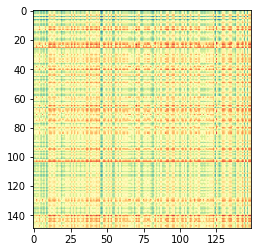

In [83]:
from matplotlib.pyplot import imshow
from PIL import Image

S = + S3 - S2 + S1
S = normalize(S)

# img = Image.fromarray(S, 'RGB')

img = S.T
imshow(img, cmap='Spectral')

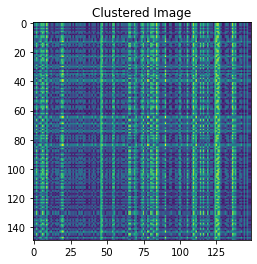

In [73]:
import matplotlib.pyplot as plt
# For clustering the image using k-means, we first need to convert it into a 2-dimensional array
image_2D = img.reshape(img.shape[0], img.shape[1])
# Use KMeans clustering algorithm from sklearn.cluster to cluster pixels in image
from sklearn.cluster import KMeans
# tweak the cluster size and see what happens to the Output
kmeans = KMeans(n_clusters=5, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]
# Reshape back the image from 2D to 3D image
clustered_3D = clustered.reshape(img.shape[0], img.shape[1])
plt.imshow(clustered_3D)
plt.title('Clustered Image')
plt.show()

### A Different Pitch Self-Similarity
Again based on the Transition matrices we will calculate the similarity measure of transition matrices differently.


For $A$ and $B$ two matrices of size $( n_1 ,m_1 )$ and $( n_2 ,m_2 )$, the distance $D( A,B )$ between these two matrices of different sizes is:
    $$ D( A,B ) = min_{\Phi, \Psi} \left( \sum_{i=1}^{min( n_1 ,n_2)} \sum_{j=1}^{min( m_1 ,m_2)} \overline{IsZero} \left( a_{\Phi( i,j )} - b_{\Psi( i,j )} \right) \right) + | n_1 - n_2 | + | m_1 - m_2 | , $$
    \begin{equation}
        \text{where} = 
            \begin{cases}
                \Phi : \{1, \dots , min(n_1, n_2) \} \times \{ 1, \dots min( m_1, min_2 ) \} \mapsto \{1, \dots n_1 \} \times \{1, \dots m_1 \} \\
                \Psi : \{1, \dots , min(n_1, n_2) \} \times \{ 1, \dots min( m_1, min_2 ) \} \mapsto \{1, \dots n_2 \} \times \{1, \dots m_2 \}
            \end{cases}
    \end{equation}

In [8]:
def n(x):
	""" IsZero complementatry function"""
	if x > 0:
		return 1
	else:
		return 0


def dist(A, B):
	"""Distance between A and B"""
	S = 0
	for i in range(0, len(A)):
		for j in range(0, len(A[0])):
			S += n(np.abs(A[i][j] - B[i][j]))
	return S


def supprimer_lignes(A, B):
	"""Sizes the two matrices lines on the same size."""
	if len(A) < len(B):

		el_a_modif = B.copy()

		el_sans_modif = A.copy()

	elif len(B) < len(A):

		el_a_modif = A.copy()

		el_sans_modif = B.copy()

	else:

		return [[A], B]
	nb_lignes_supprimer = len(el_a_modif) - len(el_sans_modif)
	combi = list(itertools.combinations(range(len(el_a_modif)), nb_lignes_supprimer))
	L = []

	for combinaison in combi:

		L.append(np.delete(el_a_modif, combinaison, 0))

	return [L, el_sans_modif]


def supprimer_colonnes(A, B):
	"""Size two matrices columns on the same size."""
	if len(A[0]) < len(B[0]):
		el_a_modif = B.copy()
		el_sans_modif = A.copy()
	elif len(B[0]) < len(A[0]):
		el_a_modif = A.copy()
		el_sans_modif = B.copy()
	else:
		return [[A], B]
	nb_colonnes_supprimer = len(el_a_modif[0]) - len(el_sans_modif[0])
	combi = list(itertools.combinations(
		range(len(el_a_modif[0])), nb_colonnes_supprimer))
	L = []
	for combinaison in combi:
		L.append(np.delete(el_a_modif, combinaison, 1))
	return [L, el_sans_modif]


def Dist(A, B):
	"""Distance between two matrices after sizing."""
	D = []
	Meme_Nb_Lignes = supprimer_lignes(A, B)
	for matrice in Meme_Nb_Lignes[0]:
		Meme_Taille = supprimer_colonnes(matrice, Meme_Nb_Lignes[1])
		for matrice_reduite in Meme_Taille[0]:
			D.append(dist(matrice_reduite, Meme_Taille[1]))
	return min(D) + np.abs(len(A) - len(B)) + np.abs(len(A[0]) - len(B[0]))

In [11]:
N = len(chords) - 2 - 1000#To lower the dimensions substract
S = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        A = np.array(M[N - i])
        B = np.array(M[j])
        S[i][j] = Dist(A, B)

KeyboardInterrupt: 

In [ ]:
from matplotlib.pyplot import imshow

img = S.T
imshow(img, cmap='Spectral')

### Yet another method for similarity using mean and maximal Transition matrices

In [42]:
def distances(A, B):
    '''Takes two transition matrices(arrays) and returns 3 real values.
    
    
    In this step we take 2 transition matrices of different sizes transform them to equal size matrices of the max
    dimension.
    Then we substract the latter matrix from the first, from these result we compute statistics.
    '''
    n1, m1 = A.shape
    n2, m2 = B.shape
    a_mean = np.array(A.mean())
    b_mean = np.array(B.mean())
    max1 = max(n1, n2)
    max2 = max(m1, m2)    
    
    if n1 < max1:
        x = np.tile(a_mean, (max1-n1,m1))
        y = np.vstack((A, x))
        A = y
        n1 = max1
    if n2 < max1:
        x = np.tile(b_mean, (max1-n2, m2 ))
        y = np.vstack((B, x))
        B = y
        n2 = max1
    if m1 < max2:
        x = np.tile(a_mean, (n1, max2 - m1 ))
        y = np.hstack((A, x))
        A = y
        m1 = max2
    if m2 < max2:
        x = np.tile(b_mean, (n2, max2 - m2))
        y = np.hstack((B, x))
        B = y
        m2 = max2
    a = A.reshape(1, max1*max2)
    b = B.reshape(1, max1*max2)
    result = b - a
    return result.var(), result.mean(), result.std()

def normalize(v):
    '''Normalize a Matrix'''
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [43]:
N = len(chords) - 2 #To lower the dimensions substract
S1 = np.zeros((N, N))
S2 = np.zeros((N, N))
S3 = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        A = np.array(M[N - i])
        B = np.array(M[j])
        S1[i][j], S2[i][j], S3[i][j] = distances(A, B)


NameError: name 'imshow' is not defined

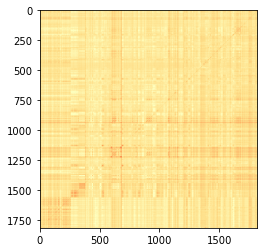

In [46]:
S = + S3 + S2 + S1
S = normalize(S)

from matplotlib.pyplot import imshow
img = S.T
imshow(img, cmap='Spectral')

## Self-Similarity using Interval Vectors

In this notebook we use self similarity matrices to study possible segmentation techniques in Symbolic music. The need of a feature space that produces elements of the same size lead us to the use of interval vectors to represent chords. Therefore our feature space $L = (\mathbb{Z}/\mathbb{Z}_{12})^6$.

Create the Selfsimilarity matrix based on the Frobenious norm:
    $$ S = [ \sum_{i, j} abs(v_i \cdot v_j)^2 ]^{\frac{1}{2}},  $$

In [10]:
import music21 as ms
import numpy as np
import partitura

FILE = "a_la_turca.musicxml"

m = ms.converter.parse(FILE)
chords = m.chordify()

intVec = list()
for thisChord in chords.recurse().getElementsByClass('Chord'):
    intVec.append(thisChord.intervalVector)
    
# part = partitura.load_musicxml(FILE)
# partitura.render(part)

In [20]:

def distance(vec1, vec2):
    comp = zip(vec1, vec2)
    l = [j - i for i, j in comp]
    return np.var(l)

def normalize(v):
    '''Normalize a Matrix'''
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

N = len(intVec) - 1
# lower the length of the analysis
S = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        S[i][j] = distance(intVec[i], intVec[N - j])
        
S = normalize(S)

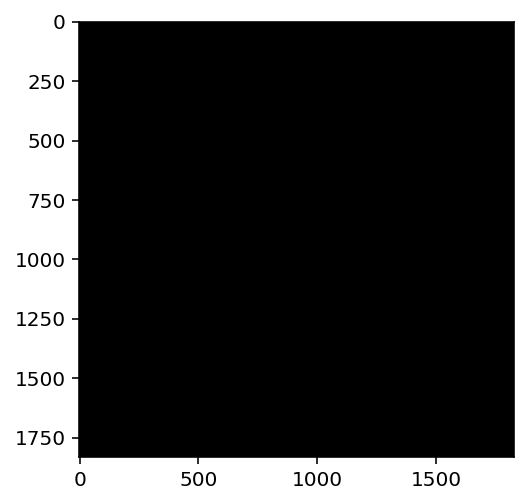

In [15]:
from matplotlib.pyplot import imshow

img = -S.T
imshow(img, cmap='gist_gray')

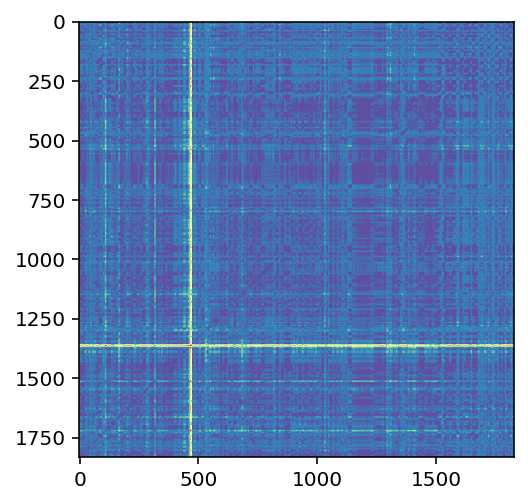

In [173]:
from skimage.morphology import erosion, dilation, binary_opening, closing
from skimage.morphology import disk, square
from skimage.segmentation import flood, flood_fill

img = -S.T
img = closing(img, square(5))
# img = binary_opening(img, square(3))

# img = flood_fill(img, (2,2),2)
# img = closing(img, square(2))

imshow(img, cmap='Spectral')

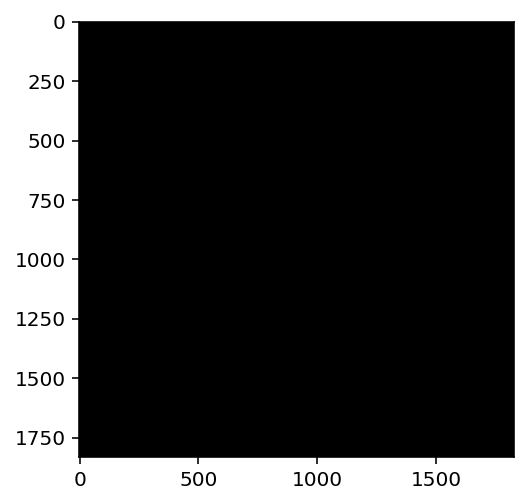

In [142]:
img = binary_opening(img, square(3))
imshow(img, cmap='gist_gray')

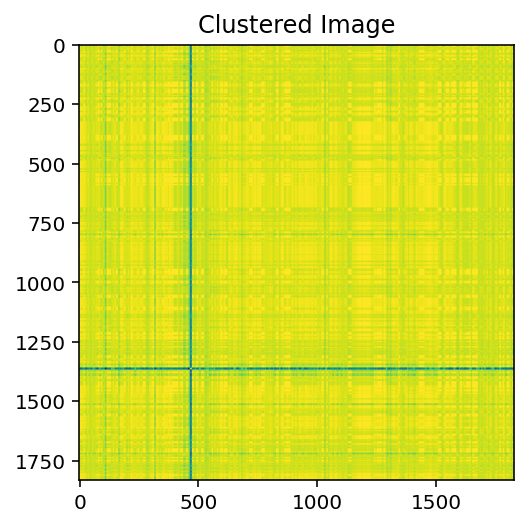

In [174]:
import matplotlib.pyplot as plt
# For clustering the image using k-means, we first need to convert it into a 2-dimensional array
image_2D = img.reshape(img.shape[0], img.shape[1])
# Use KMeans clustering algorithm from sklearn.cluster to cluster pixels in image
from sklearn.cluster import KMeans
# tweak the cluster size and see what happens to the Output
kmeans = KMeans(n_clusters=7, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]
# Reshape back the image from 2D to 3D image
clustered_3D = clustered.reshape(img.shape[0], img.shape[1])
plt.imshow(clustered_3D)
plt.title('Clustered Image')
plt.show()

## Various Similarity Measures

In this sections we will present SSMs using several different measures such as :

- Highest Voice (pitch differencial)
- Highest Voice (pitch differencial in Ternary)
- Lowest Voice (pitch differencial)
- Lowest Voice (pitch differencial in Ternary)
- Number of voices per beat change



In [31]:
highVoc = [max(c) for c in chords]
lowVoc = [max(c) for c in chords]
numOfVoc = [len(c) for c in chords]


def sign(num):
    '''simple sign function.'''
    if num>0:
        return 1
    elif num <0:
        return 0
    else:
        return -1

N = len(chords) - 1
S_high = np.zeros((N, N))
S_low = np.zeros((N, N))
S_num = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        S_high[i][j] = sign(highVoc[N-i] - highVoc[j])
        S_low[i][j] = sign(lowVoc[N-i] - lowVoc[j])
        S_num[i][j] = sign(numOfVoc[N-i] - numOfVoc[j])


In [42]:
S = np.array(list(zip(S_high, S_low, S_num)))

TypeError: Invalid shape (1817, 3, 1817) for image data

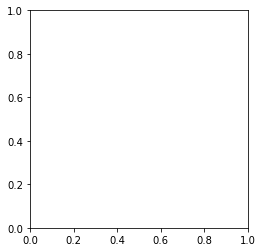

In [47]:
from matplotlib.pyplot import imshow

img = S
imshow(img, cmap='gist_gray')

# Similarity Measure with square matrices and interval vectors

The idea here is to take the interval vector of a series of notes, and move based on a certain time interval just like doing STFT. We are based on a score informed minimal and median beat. The median beat or measure is the analysis size and the minimal beat will be the step size. So we take the interval vector of the selection.

We need to build square matrices to perform the squared eucleidian distance.



In [5]:
import partitura
import numpy as np
import itertools

from showScore import showScore

In [9]:
part = partitura.load_musicxml("score_test.musicxml")
# print(part.note_array.dtype)

pianoroll = [(n.start.t, n.end.t, n.midi_pitch) for n in part.notes]
# print(pianoroll)
step = min([n[1]-n[0] for n in pianoroll])
print("The step is : ", step)
duration = pianoroll[-1][1]
print("The duration is :", duration)
# chords = [list(item[1]) for item in itertools.groupby(sorted(pianoroll), key=lambda x: x[0])]
# print(chords)

ignoring direction type: metronome {'parentheses': 'no', 'default-x': '-43.08', 'relative-y': '20.00'}


The step is :  1
The duration is : 368


In [10]:
from chords import chord_to_intervalVector

def structure_analysis(pianoroll, duration, step=1):
    dim = round((duration-(6*step))/step)+1
    X = np.zeros((dim, 6, 6))
    for i in range(1 , dim-1, step):
        rang = i*step
        for j in range(1, 7):
            x = list()
            for n in pianoroll:
                if rang <= n[0] <= rang +j*step and n[1] >= rang +j*step:
                    x.append(n[2])
            if x != []:
                interval = chord_to_intervalVector(x)
                X[i-1][j-1] = interval
    return X

def squared_distances(X, Y):
    """Return a distance matrix for each pair of rows i, j in X, Y."""
    # http://stackoverflow.com/a/19094808/166749
    X_row_norms = np.einsum('ij,ij->i', X, X)
    Y_row_norms = np.einsum('ij,ij->i', Y, Y)
    distances = np.dot(X, Y)
    distances *= -2
    distances += X_row_norms
    distances += Y_row_norms

#     np.maximum(distances, 0, distances)  # get rid of negatives; optional
    return distances

def normalize(v):
    '''Normalize a Matrix'''
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

def SSM(X):
    N = X.shape[0] - 1
    S = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            S[i][j] = np.median(normalize(squared_distances(X[N - i], X[j])))

    return S

def SSM_3dim(X):
    N = X.shape[0] - 1
    S = np.zeros((N, N, 6, 6))
    for i in range(N):
        for j in range(N):
            S[i][j] = squared_distances(X[N - i], X[j])

    return S

In [11]:
S = SSM(structure_analysis(pianoroll, duration, step))

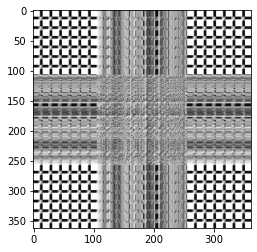

In [12]:
from matplotlib.pyplot import imshow

img = S
imshow(img, cmap='gray_r')

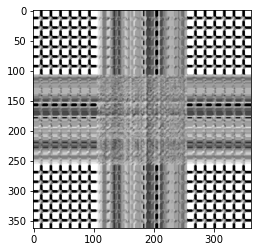

In [13]:
from matplotlib.pyplot import cm
from scipy import misc, ndimage

med_denoised = ndimage.median_filter(img, 3)
imshow(med_denoised, cmap='gray_r')

## Using Non-Negative Matrix Factorisation, PCA, and others

Attention in this chapter the structure is inversed.
So structure is outlined on the **Diagonal** and not the anti-Diagonal.

Of course when using the Interval Vector technique our matrix is of size :
    $$ X_{dur, 6, 6} $$
So we reshape it to 
    $$ X_{dur, 36} $$ 
And then we take the dot product :
    $$ X \cdot X^T $$
    
Therefore the structure is outlined on the diagonal because the common SSM is normally $X^T \cdot X$.

*NB : This method is substantially quicker than statistics.*

In [14]:
X = structure_analysis(pianoroll, duration, step)
X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
X.shape

(363, 36)

In [15]:
from sklearn.decomposition import NMF

nfm = NMF(n_components=2, init='random', random_state=0)
W = nfm.fit_transform(X)
S = (W @ W.T).T
# S = H.T @ H

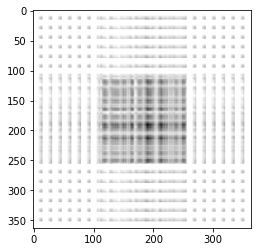

In [16]:
from matplotlib.pyplot import imshow

img = S
imshow(img, cmap='gray_r')

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
P = pca.fit_transform(X)
S = P @ P.T

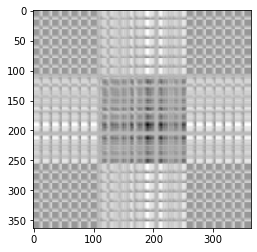

In [18]:
img = S.T
imshow(img, cmap='gray_r')

#### Non-Negative Tucker Decomposition

In [19]:
from tensorly.decomposition import non_negative_tucker
core, factors = non_negative_tucker(X, rank=(12, 12, 1), n_iter_max=1000)
S = factors[0] @ factors[0].T

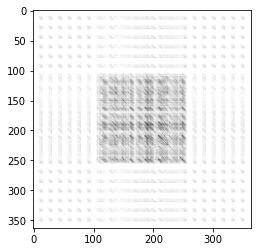

In [20]:
img = S.T
imshow(img, cmap='gray_r')